In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%run ../aux_funcs.py
%run ../RSRG.py
%run ../RSRG_class.py

In [3]:
ts = "1677145967"

with open("Ising_2D_output_"+ts+".pkl", "rb") as fp:   # Unpickling
    output_data = pickle.load(fp)

with open("Ising_2D_input_"+ts+".pkl", "rb") as fp:   
    input_dict = pickle.load(fp)
    
Omegas = np.array([])
dec_types = np.array([])
h_array, J_array = [], []


for core, item in enumerate(output_data):
    J_dist_list, h_dist_list, Omega_list_composite, decimation_type_composite = item
    Omegas = np.concatenate((Omegas, Omega_list_composite))
    dec_types = np.concatenate((dec_types, decimation_type_composite))
    if core==0:
        h_array = h_dist_list
        J_array = J_dist_list

    else:
        for i in range(len(input_dict['measure_list'])):
            h_array[i] = np.concatenate((h_array[i], h_dist_list[i]))
            J_array[i] = np.concatenate((J_array[i], J_dist_list[i]))
        
        
with open("Ising_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)
    
print(input_dict)

{'L': 20, 'steps': 380, 'measure_list': array([400, 342, 293, 251, 215, 184, 157, 135, 115,  99,  84,  72,  62,
        53,  45,  39,  33,  28,  24,  21]), '(a,b,w)': (0.1, 0.105, 4.5), 'n_runs': 12}


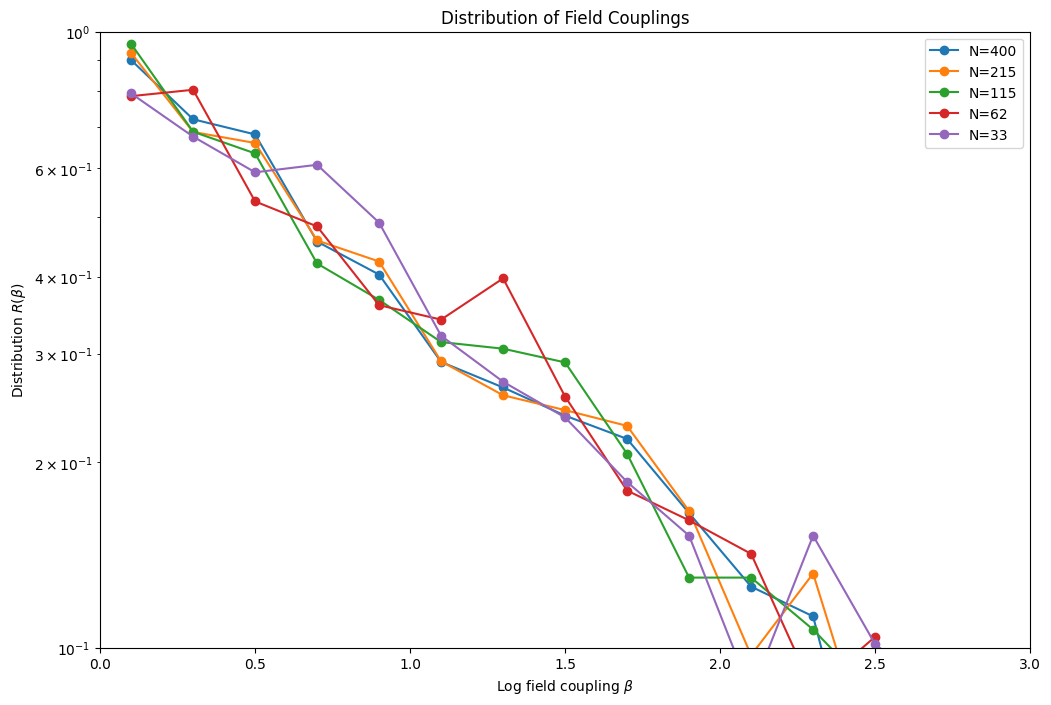

In [7]:
measure_list = input_dict['measure_list']
n_runs = input_dict['n_runs']
n_bins_h = 60

plt.figure(figsize=(12, 8))

for i,step in enumerate(measure_list):
    if i%4==0: 
        n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
        width = bins[1]-bins[0]
        plt.plot((bins[1:]-width/2), n, label="N="+str(step), marker='o')

plt.yscale('log')
plt.xlim(0, 3)
plt.ylim(1e-1, 1)

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
plt.legend()

In [8]:
clust_dict_list, reverse_dict_list = [], []

for core_pair in clust_list_final:
    clust_list_temp, reverse_list_temp = core_pair
    clust_dict_list+=clust_list_temp
    reverse_dict_list+=reverse_list_temp

In [9]:
#for clust_dict in clust_dict_list:
#    print(clust_dict[0])
    
largest_clust_list = [max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list]

largest_clust_list

[5, 3, 3, 3]